# Portfolio Optimization Report

This notebook provides a comprehensive workflow for portfolio optimization using 10 years of weekly market data for various ETFs. The workflow includes:
- Data acquisition and cleaning
- Exploratory data analysis and visualization
- Risk and return statistics
- Downside and tail risk analysis
- Factor regressions (CAPM & Multi-Factor)
- Portfolio optimization with constraints
- Generation of summary tables, charts, and a PDF report

Each section is explained in detail below.

## 1. Library Installation and Imports

This block checks for required Python libraries, installs any that are missing, and imports all necessary standard, data science, and finance libraries. It also sets up matplotlib plotting styles for consistent visuals.

In [1]:
# -*- coding: utf-8 -*-
"""
Portfolio Optimization Report
-----------------------------
This notebook downloads 10 years of weekly market data for various ETFs using yfinance.
It calculates returns, performs optimization, runs factor regressions (CAPM & Multi-Factor),
and generates clean PDF reports with matplotlib and plotly.

Outputs:
- Data CSV
- Portfolio charts
- Summary PDF report
"""


# === 1. STANDARD LIBRARIES ===
import os
import sys
import subprocess
from pathlib import Path
from datetime import datetime, timedelta
import io
from io import StringIO
from contextlib import redirect_stdout

# === 2. LIBRARY CHECK & INSTALLATION ===
required_libraries = [
    "yfinance", "pandas", "pandas_datareader", "matplotlib", "numpy", "seaborn",
    "arch", "plotly", "statsmodels", "nbformat", "nbconvert", "ipykernel", 
    "ipywidgets", "scipy", "kaleido"
]

missing_libraries = []
for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        missing_libraries.append(lib)

if missing_libraries:
    print(f"Installing missing libraries: {', '.join(missing_libraries)}...")
    for lib in missing_libraries:
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib])
else:
    print("All required libraries are installed.")

# === 3. CORE PYTHON LIBRARIES ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
import statsmodels.api as sm

# === 4. FINANCE / ECONOMIC LIBRARIES ===
import yfinance as yf
import pandas_datareader.data as web
from arch import arch_model

# === 5. INTERACTIVE & STATIC PLOTTING ===
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
from matplotlib.backends.backend_pdf import PdfPages

# === 6. MATPLOTLIB STYLE SETTINGS ===
plt.style.use("tableau-colorblind10")
plt.rcParams.update({
    "font.size": 10,
    "font.family": "sans-serif",
    "axes.titleweight": "bold",
    "axes.labelsize": 8,
    "axes.titlesize": 14,
    "grid.alpha": 0.3,
    "legend.frameon": False,
    "figure.dpi": 75
})

# --- used for generating the report ---
figures = []
SEED = 23
np.random.seed(SEED)


All required libraries are installed.


## 2. Data Loading and Portfolio Details

- Reads portfolio details (tickers, constraints, risk-free rate) from a configuration file.
- Downloads 10 years of weekly close prices for the specified ETFs.
- Renames columns to asset classes and saves the cleaned data to CSV.
- Displays a summary of the parsed portfolio details and data columns.

In [2]:
# === DATA DIRECTORY SETUP ===

# === Read and parse portfolio file ===
with open("port_details.txt", "r") as file:
    lines = file.readlines()

tickers = {}
constraints = {}
risk_free_rate = None
section = None

for line in lines:
    line = line.strip()
    if not line:
        continue
    elif line.endswith(":") and line.count(":") == 1:
        section = line[:-1]
    elif section == "Tickers":
        key, value = line.split(": ")
        tickers[key.strip()] = value.strip()
    elif section == "Risk-free Rate":
        risk_free_rate = float(line.strip())
    elif section == "Investment Constraints":
        if "<=" in line:
            key, value = line.split(" <= ")
            key = key.strip().rstrip(":")
            value = float(value.strip().strip("%")) / 100
            constraints.setdefault(key, {})["max"] = value
        elif ">=" in line or ">" in line:
            key, value = line.split(" > ")
            key = key.strip().rstrip(":")
            value = float(value.strip().strip("%")) / 100
            constraints.setdefault(key, {})["min"] = value

# === Define date range ===
end_date = datetime(2025, 6, 13)
start_date = end_date - timedelta(weeks=52 * 10)

# === Download weekly close prices ===
data = yf.download(
    tickers=list(tickers.values()),
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval="1wk",
    auto_adjust=False,
    back_adjust=False
)["Close"]

# === Rename columns to asset classes ===
ticker_to_asset = {v: k for k, v in tickers.items()}
data = data.rename(columns=ticker_to_asset)

priority = ['US_Stocks', 'US_Bonds', 'Dev_Stocks_ExUS', 'Dev_Bonds_ExUS',
            'EM_Stocks', 'EM_Bonds', 'Cash']
rest = [col for col in data.columns if col not in priority]
data = data[priority + rest]

# === Save data to CSV ===
os.makedirs("exports", exist_ok=True)
data.to_csv("exports/weekly_market_data_10yr_combined.csv")
print("Saved as 'weekly_market_data_10yr_combined.csv' in exports directory.")

# === Print data columns and parsed details ===
print("\nData Columns:")
print(", ".join(data.columns))

print("\nParsed Portfolio Details:")
print("Tickers:", tickers)
print("Risk-Free Rate:", risk_free_rate)
print("Constraints:", constraints)

[*********************100%***********************]  8 of 8 completed

Saved as 'weekly_market_data_10yr_combined.csv' in exports directory.

Data Columns:
US_Stocks, US_Bonds, Dev_Stocks_ExUS, Dev_Bonds_ExUS, EM_Stocks, EM_Bonds, Cash, Gold

Parsed Portfolio Details:
Tickers: {'US_Stocks': 'VOO', 'US_Bonds': 'AGG', 'Dev_Stocks_ExUS': 'SCHF', 'Dev_Bonds_ExUS': 'BNDX', 'EM_Stocks': 'VWO', 'EM_Bonds': 'EMB', 'Cash': 'BIL', 'Gold': 'GLD'}
Risk-Free Rate: 0.0441
Constraints: {'US_Stocks': {'max': 0.65, 'min': 0.1}, 'US_Bonds': {'max': 0.5, 'min': 0.2}, 'Dev_Stocks_ExUS': {'max': 0.4}, 'Dev_Bonds_ExUS': {'max': 0.4}, 'EM_Bonds': {'max': 0.15}, 'EM_Stocks': {'max': 0.15}, 'Cash': {'max': 0.1}, 'Gold': {'max': 0.15}}


## 3. Portfolio Metadata and Constraints Overview

- Creates summary tables for portfolio metadata (risk-free rate, date range, asset count) and asset class tickers.
- Visualizes asset allocation constraints as a bar chart.
- Adds these visuals to the report figures for later export.

C:\Users\opelc\AppData\Local\Temp\ipykernel_42724\2156783288.py:65: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



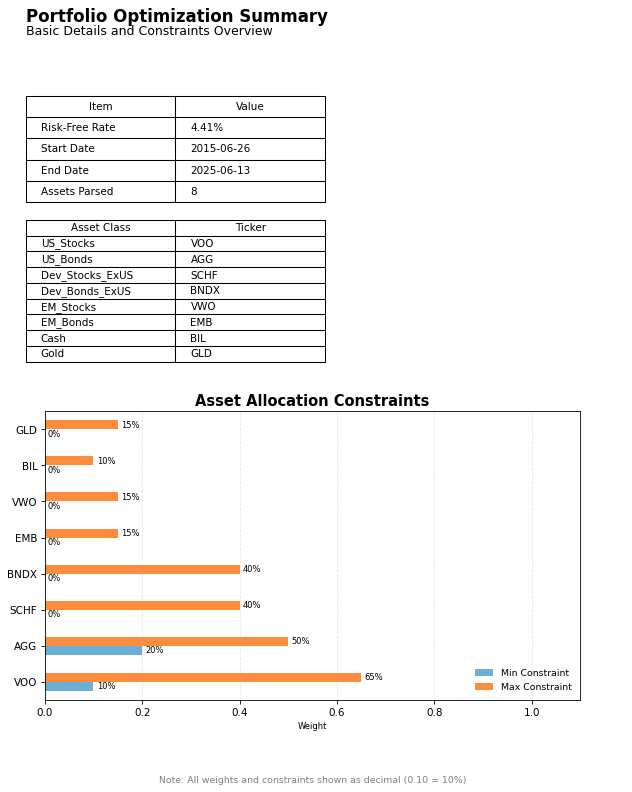

In [3]:
# === Metadata table ===
metadata_df = pd.DataFrame({
    "Item": ["Risk-Free Rate", "Start Date", "End Date", "Assets Parsed"],
    "Value": [f"{risk_free_rate:.2%}", start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"), len(tickers)]
})

# === Asset class table ===
asset_df = pd.DataFrame(list(tickers.items()), columns=["Asset Class", "Ticker"])


# === Constraints DataFrame ===
constraint_df = pd.DataFrame(index=[tickers[k] for k in constraints.keys()])
constraint_df['Min'] = [v.get('min', 0) for v in constraints.values()]
constraint_df['Max'] = [v.get('max', 1) for v in constraints.values()]

# === Create full-page figure ===
fig_combined = plt.figure(figsize=(8.5, 11))

# --- Section 1: Metadata and Asset Classes ---
ax_text = fig_combined.add_axes([0.05, 0.53, 0.94, 0.43])  # shifted up slightly
ax_text.axis('off')

# Title and subtitle
ax_text.text(0, 1.0, "Portfolio Optimization Summary", fontsize=16, weight='bold', va='top')
ax_text.text(0, 0.95, "Basic Details and Constraints Overview", fontsize=12, va='top')

# Metadata Table
table1 = ax_text.table(cellText=metadata_df.values,
                       colLabels=metadata_df.columns,
                       cellLoc='left',
                       loc='upper left',
                       bbox=[0, 0.45, 0.5, 0.3])
table1.auto_set_font_size(False)
table1.set_fontsize(10)

# Asset Table
table2 = ax_text.table(cellText=asset_df.values,
                       colLabels=asset_df.columns,
                       cellLoc='left',
                       loc='upper left',
                       bbox=[0, 0.0, 0.5, 0.4])
table2.auto_set_font_size(False)
table2.set_fontsize(10)

# === Section 2: Horizontal Constraints Chart ===
ax_bar = fig_combined.add_axes([0.08, 0.12, 0.84, 0.35])  # moved up to leave room for footer

constraint_df.plot(kind='barh', ax=ax_bar, color=["#6baed6", "#fd8d3c"])

ax_bar.set_title("Asset Allocation Constraints")
ax_bar.set_xlabel("Weight")
ax_bar.set_xlim(0, 1.1)
ax_bar.grid(axis='x', linestyle='--', alpha=0.3)
ax_bar.legend(["Min Constraint", "Max Constraint"], loc='lower right', fontsize=9)

# Add bar labels
for bars in ax_bar.containers:
    ax_bar.bar_label(bars, labels=[f"{v:.0%}" for v in bars.datavalues], label_type='edge', fontsize=8, padding=3)

# === Footer note (adjusted to bottom center) ===
fig_combined.text(0.5, 0.02, "Note: All weights and constraints shown as decimal (0.10 = 10%)", 
                  fontsize=9, color="gray", ha="center")

# Final layout
fig_combined.tight_layout()
figures.append(fig_combined)

## 4. Price and Return Series Visualization

- Calculates weekly simple and log returns, as well as cumulative returns for each asset.
- Plots:
  - 10-year weekly price series
  - Cumulative returns (base = 100)
  - Cumulative log returns
- Adds these charts to the report figures.

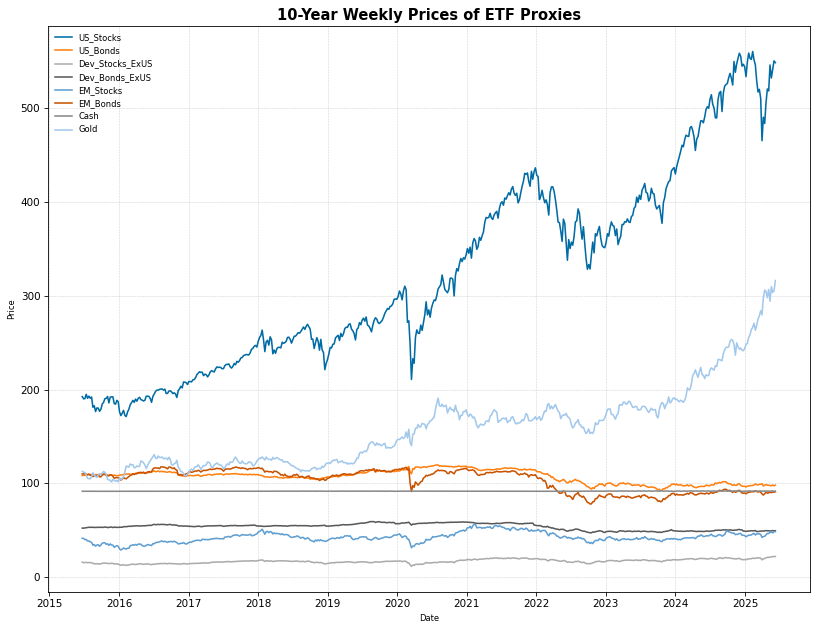

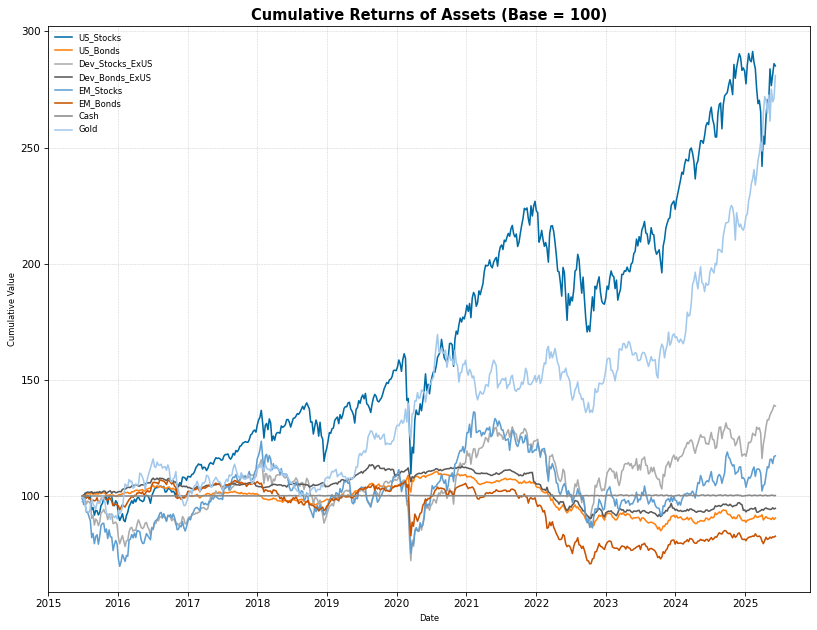

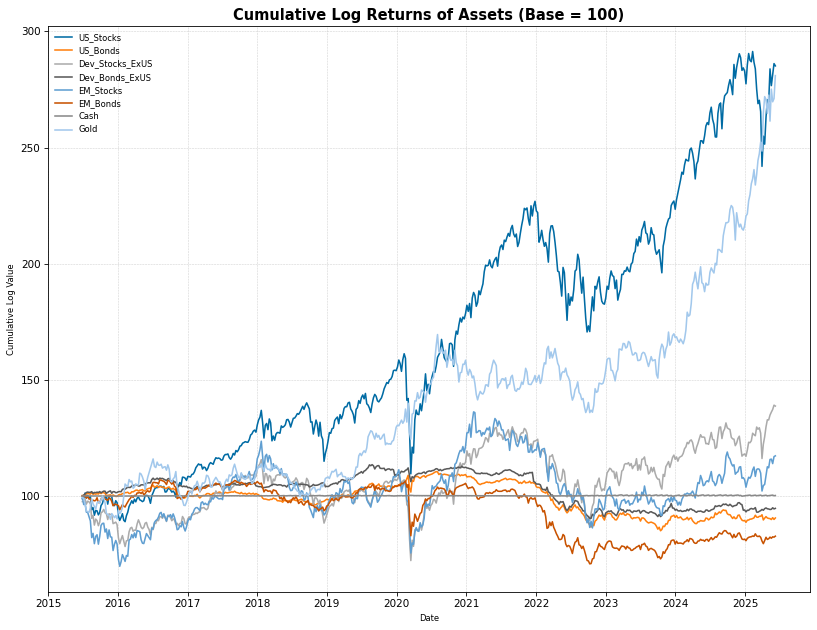

In [4]:
# === Setup: calculate required series ===
simple_returns = data.pct_change().dropna()
cumulative_returns = (1 + simple_returns).cumprod() * 100

log_returns = np.log(data / data.shift(1)).dropna()
cum_log_returns = np.exp(log_returns.cumsum()) * 100

# === 1. Weekly Prices Line Chart ===
fig_prices, ax1 = plt.subplots(figsize=(11, 8.5))
for col in data.columns:
    ax1.plot(data.index, data[col], label=col)

ax1.set_title('10-Year Weekly Prices of ETF Proxies', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax1.legend(loc='upper left', fontsize=8)
plt.tight_layout()
figures.append(fig_prices)

# === 2. Cumulative Returns Line Chart ===
fig_cum, ax2 = plt.subplots(figsize=(11, 8.5))
for col in cumulative_returns.columns:
    ax2.plot(cumulative_returns.index, cumulative_returns[col], label=col)

ax2.set_title('Cumulative Returns of Assets (Base = 100)', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Value')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax2.legend(loc='upper left', fontsize=8)
plt.tight_layout()
figures.append(fig_cum)

# === 3. Cumulative Log Returns Line Chart ===
fig_log, ax3 = plt.subplots(figsize=(11, 8.5))
for col in cum_log_returns.columns:
    ax3.plot(cum_log_returns.index, cum_log_returns[col], label=col)

ax3.set_title('Cumulative Log Returns of Assets (Base = 100)', fontsize=14)
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Log Value')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax3.legend(loc='upper left', fontsize=8)
plt.tight_layout()
figures.append(fig_log)

## 5. Descriptive Statistics of Asset Returns

- Computes annualized mean, standard deviation, Sharpe ratio, skewness, kurtosis, and extreme returns for each asset.
- Formats and displays these statistics in a summary table, sorted by Sharpe ratio.
- Adds the table to the report figures.

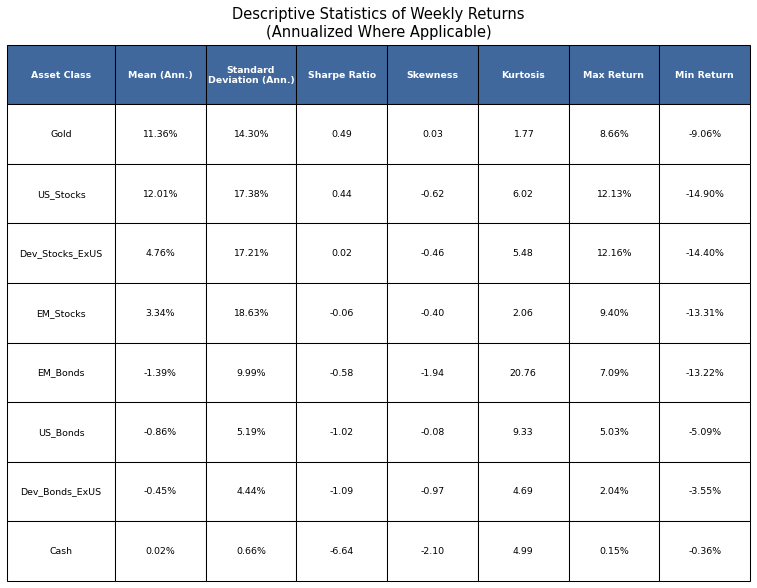

In [5]:
# Descriptive statistics for ETF weekly return series
assets =  data.columns
desc_stats = pd.DataFrame(index=assets)

# Mean (expected return, annualized)
desc_stats['Mean (Ann.)'] = simple_returns.mean() * 52

# Standard deviation (volatility, annualized)
desc_stats['Standard\nDeviation (Ann.)'] = simple_returns.std() * np.sqrt(52)

# Skewness (asymmetry)
desc_stats['Skewness'] = simple_returns.skew()

# Kurtosis (fat tails)
desc_stats['Kurtosis'] = simple_returns.kurtosis()

# Max/min weekly returns
desc_stats['Max Return'] = simple_returns.max()
desc_stats['Min Return'] = simple_returns.min()

# Sharpe Ratio (annualized)
desc_stats['Sharpe Ratio'] = (simple_returns.mean() * 52 - risk_free_rate) / (simple_returns.std() * np.sqrt(52))

desc_stats = desc_stats.reset_index()
desc_stats = desc_stats.rename(columns={'Ticker': 'Asset Class'})
# Reorder columns for better readability
desc_stats = desc_stats[['Asset Class', 'Mean (Ann.)', 'Standard\nDeviation (Ann.)',
                         'Sharpe Ratio', 'Skewness', 'Kurtosis',
                         'Max Return', 'Min Return']]
# Sort by Sharpe Ratio
desc_stats = desc_stats.sort_values(by='Sharpe Ratio', ascending=False)

# === Format Values ===
formatted_desc_stats = desc_stats.copy()

# Format percentages
cols_pct = ['Mean (Ann.)', 'Standard\nDeviation (Ann.)', 'Max Return', 'Min Return']
for col in cols_pct:
    formatted_desc_stats[col] = formatted_desc_stats[col].map(lambda x: f"{x:.2%}")

# Format numeric ratios
formatted_desc_stats['Sharpe Ratio'] = formatted_desc_stats['Sharpe Ratio'].apply(lambda x: f"{x:.2f}")
formatted_desc_stats['Skewness'] = formatted_desc_stats['Skewness'].apply(lambda x: f"{x:.2f}")
formatted_desc_stats['Kurtosis'] = formatted_desc_stats['Kurtosis'].apply(lambda x: f"{x:.2f}")

# === Create Table ===
fig_stats = plt.figure(figsize=(11, 8.5))
ax = fig_stats.add_axes([0.05, 0.08, 0.9, 0.84])
ax.axis('off')

table = ax.table(
    cellText=formatted_desc_stats.values,
    colLabels=formatted_desc_stats.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.13] + [0.11] * (formatted_desc_stats.shape[1] - 1),
    bbox=[0, 0, 1, 1]
)

header_props = {
    "facecolor": "#40689c",
    "edgecolor": "white",
    "text_props": {
        "weight": "bold",
        "color": "white",
        "fontsize": 10
    }
}

# Apply formatting to each header cell
for col_idx in range(len(formatted_desc_stats.columns)):
    cell = table[(0, col_idx)]
    cell.set_facecolor(header_props["facecolor"])
    cell.get_text().set_fontweight(header_props["text_props"]["weight"])
    cell.get_text().set_color(header_props["text_props"]["color"])
    cell.get_text().set_fontsize(header_props["text_props"]["fontsize"])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

plt.suptitle("Descriptive Statistics of Weekly Returns\n(Annualized Where Applicable)", fontsize=14, y=0.98)
figures.append(fig_stats)


## 6. Correlation Analysis

- Plots a heatmap of weekly return correlations between all asset classes.
- Helps visualize diversification and relationships among assets.

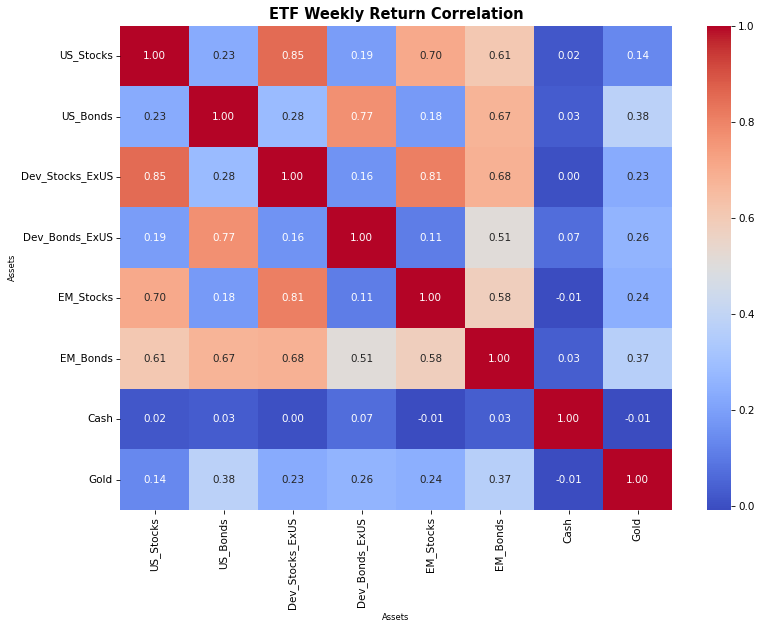

In [6]:
# === 4. Correlation Heatmap ===

fig_corr = plt.figure(figsize=(11, 8.5))
sns.heatmap(simple_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("ETF Weekly Return Correlation")
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.tight_layout()
plt.show()
figures.append(fig_corr)

## 7. Hierarchical Clustering of Asset Correlations

- Reorders the correlation matrix using hierarchical clustering.
- Visualizes the reordered matrix as a heatmap to reveal asset groupings and clusters.

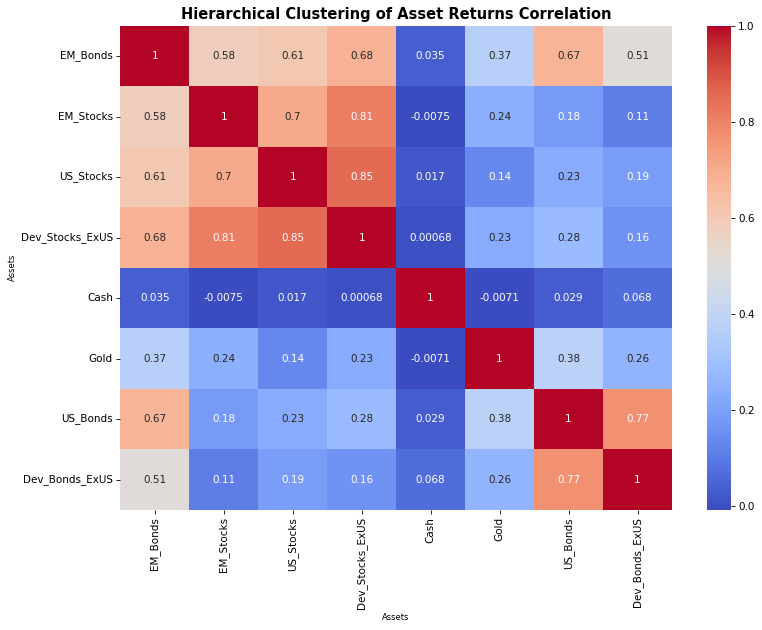

In [7]:
# === Hierarchical Clustering of Correlation Matrix ===
# This section performs hierarchical clustering on the correlation matrix of asset returns
# Reorder based on clustering
corr_matrix = simple_returns.corr()
link = linkage(corr_matrix, method='ward')
order = leaves_list(link)
ordered_corr = corr_matrix.iloc[order, order]
fig_corr_clustered = plt.figure(figsize=(11, 8.5))
sns.heatmap(ordered_corr, cmap='coolwarm', annot=True)
plt.title("Hierarchical Clustering of Asset Returns Correlation")
plt.xlabel("Assets")
plt.ylabel("Assets")
plt.tight_layout()
figures.append(fig_corr_clustered)


## 8. Correlation with US Stocks

- Plots a horizontal bar chart showing the correlation of each asset's returns with US Stocks.
- Useful for understanding which assets move together with the US equity market.

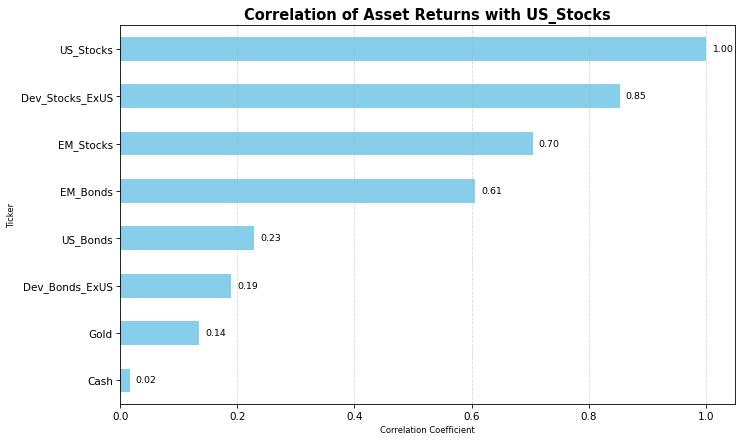

In [8]:
# === Correlation Bar Chart vs US Stocks ===
# This section calculates the correlation of each asset's returns with US Stocks and plots it as a bar chart
# Ensure 'US_Stocks' is in the data

ref_asset = 'US_Stocks'
corr_vs_us = simple_returns.corr()[ref_asset].sort_values()

fig_corr_bar, ax = plt.subplots(figsize=(10, 6))
bars = corr_vs_us.plot(kind='barh', color='skyblue', ax=ax)

ax.set_title(f"Correlation of Asset Returns with {ref_asset}")
ax.set_xlabel("Correlation Coefficient")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

# Add bar labels
for i, v in enumerate(corr_vs_us):
    ax.text(v + 0.01 if v >= 0 else v - 0.1, i, f"{v:.2f}",
            va='center', ha='left' if v >= 0 else 'right', fontsize=9)

plt.tight_layout()
figures.append(fig_corr_bar)

## 9. Downside and Tail Risk Metrics

- Calculates Value at Risk (VaR), Conditional VaR (CVaR), maximum drawdown, and beta for each asset.
- Optionally computes GARCH volatility.
- Formats and displays these risk metrics in a summary table.

C:\Users\opelc\AppData\Local\Temp\ipykernel_42724\3819899184.py:91: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



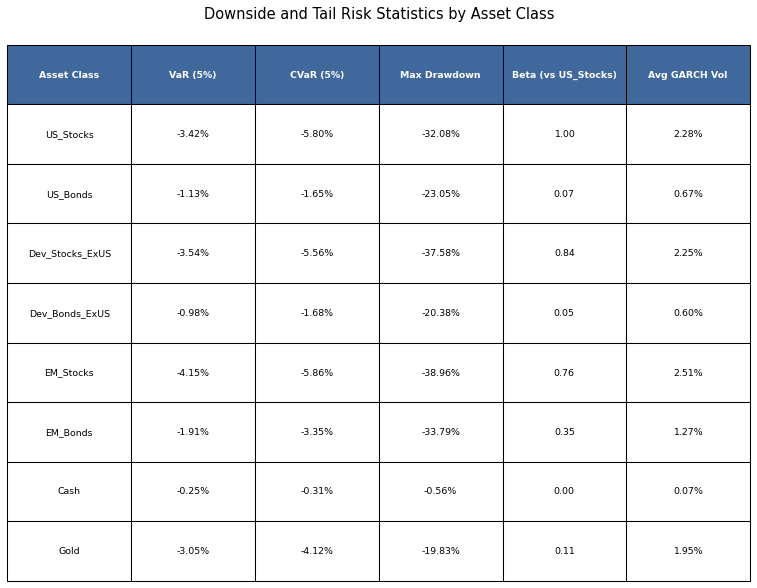

In [9]:
# === 5. Downside and Tail Risk Statistics ===
# This section calculates various downside and tail risk statistics for the asset returns

# 1. Value at Risk (VaR) at 5% level
VaR_5 = simple_returns.quantile(0.05)

# 2. Conditional Value at Risk (CVaR) at 5% level
CVaR_5 = simple_returns[simple_returns.lt(VaR_5)].mean()

# 3. Maximum drawdown
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

max_dd = simple_returns.apply(max_drawdown)

# 4. Beta vs. US Stocks
us_stock_returns = simple_returns['US_Stocks']
betas = {}
for asset in assets:
    if asset == 'US_Stocks':
        betas[asset] = 1.0
    else:
        cov = simple_returns[asset].cov(us_stock_returns)
        var = us_stock_returns.var()
        betas[asset] = cov / var

betas = pd.Series(betas)

# Compile results
risk_stats = pd.DataFrame({
    'VaR (5%)': VaR_5,
    'CVaR (5%)': CVaR_5,
    'Max Drawdown': max_dd,
    'Beta (vs US_Stocks)': betas
})

try:
    garch_vols = {}
    for asset in assets:
        am = arch_model(simple_returns[asset]*100, vol='Garch', p=1, q=1, rescale=False)
        res = am.fit(disp='off')
        garch_vols[asset] = res.conditional_volatility.mean() / 100  # Convert back to original scale
    risk_stats['Avg GARCH Vol'] = pd.Series(garch_vols)
except ImportError:
    print("arch package not installed. Skipping GARCH volatility modeling.")

# === Format downside risk stats for display ===
risk_stats_fmt = risk_stats.copy().round(4).reset_index().rename(columns={'index': 'Asset Class'})

# Format columns as percentages
cols_pct = ['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']
for col in cols_pct:
    risk_stats_fmt[col] = risk_stats_fmt[col].map(lambda x: f"{x:.2%}")

# Format Beta
risk_stats_fmt['Beta (vs US_Stocks)'] = risk_stats_fmt['Beta (vs US_Stocks)'].map(lambda x: f"{x:.2f}")

# === Create Matplotlib figure and axes ===
fig_risk = plt.figure(figsize=(11, 8.5))
ax = fig_risk.add_axes([0.05, 0.08, 0.9, 0.84])  # slightly inset to leave room for title
ax.axis('off')

# === Create the table ===
table = ax.table(
    cellText=risk_stats_fmt.values,
    colLabels=risk_stats_fmt.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1],
    colWidths=[0.13] + [0.13] * (risk_stats_fmt.shape[1] - 1)
)

# === Format header row ===
for col_idx in range(len(risk_stats_fmt.columns)):
    cell = table[(0, col_idx)]
    cell.set_facecolor("#40689c")          # dark blue
    cell.get_text().set_fontweight("bold")
    cell.get_text().set_color("white")
    cell.get_text().set_fontsize(10)

# === General formatting ===
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

# === Add title ===
plt.suptitle("Downside and Tail Risk Statistics by Asset Class", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# === Add to figures list for PDF export ===
figures.append(fig_risk)

## 10. Downside Risk Bar Chart and Table

- Visualizes VaR, CVaR, max drawdown, and GARCH volatility for each asset as a horizontal bar chart.
- Displays a formatted table of these metrics below the chart.
- Adds the figure to the report.

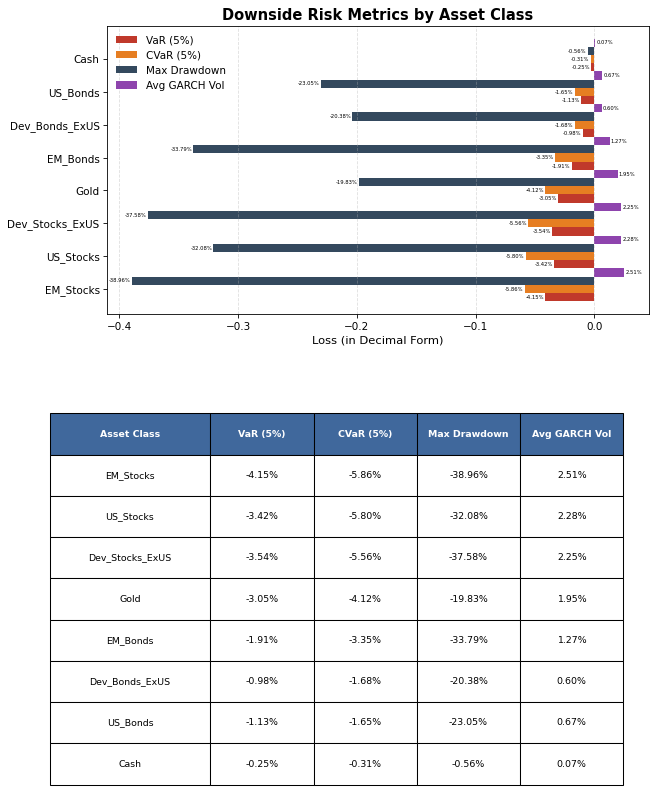

In [10]:
# === Export risk statistics table to PDF ===

# Simulated already-formatted risk_stats (as the user has it)
risk_stats_plot = risk_stats[['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']].copy()
risk_stats_plot = risk_stats_plot.sort_values('CVaR (5%)')  # Sort to highlight exposure

# Convert figure size to portrait layout (8.5 x 11 inches)
fig_combined_portrait = plt.figure(figsize=(8.5, 11))

# === Top Plot Area ===
ax_chart = fig_combined_portrait.add_axes([0.1, 0.58, 0.85, 0.35])  # Adjusted for portrait layout

bar_width = 0.25
index = np.arange(len(risk_stats_plot))

bars_var = ax_chart.barh(index - bar_width, risk_stats_plot['VaR (5%)'], height=bar_width, label='VaR (5%)', color='#c0392b')
bars_cvar = ax_chart.barh(index, risk_stats_plot['CVaR (5%)'], height=bar_width, label='CVaR (5%)', color='#e67e22')
bars_dd = ax_chart.barh(index + bar_width, risk_stats_plot['Max Drawdown'], height=bar_width, label='Max Drawdown', color='#34495e')
bars_garch = ax_chart.barh(index + 2 * bar_width, risk_stats_plot['Avg GARCH Vol'], height=bar_width, label='Avg GARCH Vol', color='#8e44ad')   

# Add text labels
for bars in [bars_var, bars_cvar, bars_dd, bars_garch]:
    for bar in bars:
        width = bar.get_width()
        ax_chart.text(
            width - 0.001 if width < 0 else width + 0.001,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2%}",
            ha='right' if width < 0 else 'left',
            va='center',
            fontsize=5,
            color='black'
        )

ax_chart.set_yticks(index)
ax_chart.set_yticklabels(risk_stats_plot.index)
ax_chart.set_xlabel("Loss (in Decimal Form)", fontsize=11)
ax_chart.set_title("Downside Risk Metrics by Asset Class", fontsize=14)
ax_chart.legend()
ax_chart.grid(True, axis='x', linestyle='--', alpha=0.4)

# === Table Below Chart ===
ax_table = fig_combined_portrait.add_axes([0.01, 0.01, 0.9, 0.45])
ax_table.axis('off')

# Table formatting
risk_table_fmt = risk_stats_plot.copy().round(4).reset_index().rename(columns={"index": "Asset Class"})
for col in ['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']:
    risk_table_fmt[col] = risk_table_fmt[col].map(lambda x: f"{x:.2%}")

table = ax_table.table(
    cellText=risk_table_fmt.values,
    colLabels=risk_table_fmt.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.28, 0.18, 0.18, 0.18, 0.18],
    bbox=[0, 0, 1, 1]
)

# Header formatting
for col_idx in range(len(risk_table_fmt.columns)):
    cell = table[(0, col_idx)]
    cell.set_facecolor("#40689c")
    cell.get_text().set_fontweight("bold")
    cell.get_text().set_color("white")
    cell.get_text().set_fontsize(10)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

figures.append(fig_combined_portrait)

## 11. Downside Risk Heatmap

- Creates a heatmap of downside risk metrics (VaR, CVaR, max drawdown, GARCH volatility) for all assets.
- Higher values indicate greater risk exposure.

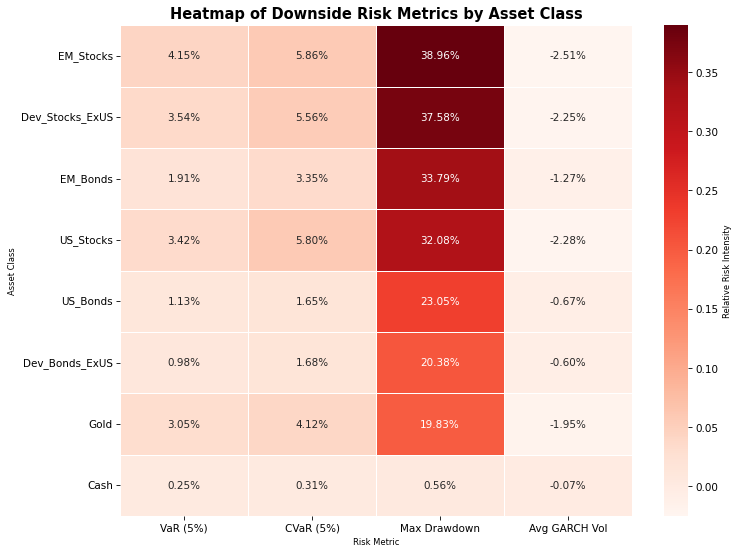

In [11]:
# === Create Heatmap of Downside Risk Metrics ===
# This section creates a heatmap visualization of the downside risk metrics

# Use downside risk metrics
available_metrics = ['VaR (5%)', 'CVaR (5%)', 'Max Drawdown', 'Avg GARCH Vol']
risk_heatmap_data = risk_stats[available_metrics].copy()
risk_heatmap_data = risk_heatmap_data.sort_values('Max Drawdown')  # Sort by CVaR for better visualization

# Flip signs so higher values = higher risk (for heatmap visualization)
risk_heatmap_flipped = risk_heatmap_data.copy()
risk_heatmap_flipped[available_metrics] = -risk_heatmap_flipped[available_metrics]

# Create heatmap
fig_heatmap, ax = plt.subplots(figsize=(11, 8.5))

sns.heatmap(
    risk_heatmap_flipped,
    annot=True,
    fmt=".2%",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={"label": "Relative Risk Intensity"},
    ax=ax
)

ax.set_title("Heatmap of Downside Risk Metrics by Asset Class", fontsize=14)
ax.set_ylabel("Asset Class")
ax.set_xlabel("Risk Metric")

figures.append(fig_heatmap)

## 12. Drawdown Curve Plotting Function

Defines a function to plot cumulative return and drawdown curves for a given asset, highlighting periods of significant drawdown. Used for visualizing risk and recovery patterns.

In [12]:
def plot_drawdown_curve(asset_name, returns_series, figures_list, threshold=-0.10):
    """
    Plot cumulative return and drawdown curve with drawdown periods highlighted.

    Parameters:
        asset_name (str): Name of the asset (e.g., 'US_Stocks')
        returns_series (pd.Series): Weekly or monthly returns for the asset
        figures_list (list): Your global list to append the figure for PDF export
    """
    # Compute cumulative return
    cumulative = (1 + returns_series).cumprod()

    # Compute drawdown
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak

    # Ensure float for plotting
    drawdown = drawdown.astype(float)

    # Create 2-row subplot layout
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(11, 8.5), sharex=True,
        gridspec_kw={'height_ratios': [2, 1]}
    )

    # === Top Panel: Cumulative Returns ===
    ax1.plot(cumulative.index, cumulative, color='green', linewidth=1.5)
    ax1.set_title(f"Cumulative Return - {asset_name}", fontsize=14)
    ax1.set_ylabel("Cumulative Value")
    ax1.grid(True, linestyle='--', alpha=0.4)

    # Highlight drawdown periods greater than 10%
    threshold = threshold # 10% drawdown
    drawdown_start = None

    for i in range(len(drawdown)):
        if drawdown.iloc[i] <= threshold and drawdown_start is None:
            drawdown_start = drawdown.index[i]
        elif drawdown.iloc[i] > threshold and drawdown_start is not None:
            ax1.axvspan(drawdown_start, drawdown.index[i], color='red', alpha=0.15)
            drawdown_start = None

    # Handle edge case: still in drawdown at end
    if drawdown_start is not None and drawdown.iloc[-1] <= threshold:
        ax1.axvspan(drawdown_start, drawdown.index[-1], color='red', alpha=0.15)


    # === Bottom Panel: Drawdown Curve ===
    ax2.fill_between(drawdown.index, drawdown.values, 0, color='salmon', alpha=0.8)
    ax2.set_title("Drawdown Curve", fontsize=12)
    ax2.set_ylabel("Drawdown")
    ax2.set_xlabel("Date")
    ax2.grid(True, linestyle='--', alpha=0.4)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    plt.tight_layout()
    figures_list.append(fig)  # Add to export list

## 13. Drawdown Curves for Selected Assets

- Plots cumulative return and drawdown curves for US Stocks, US Bonds, and Gold.
- Highlights periods where drawdowns exceed specified thresholds.

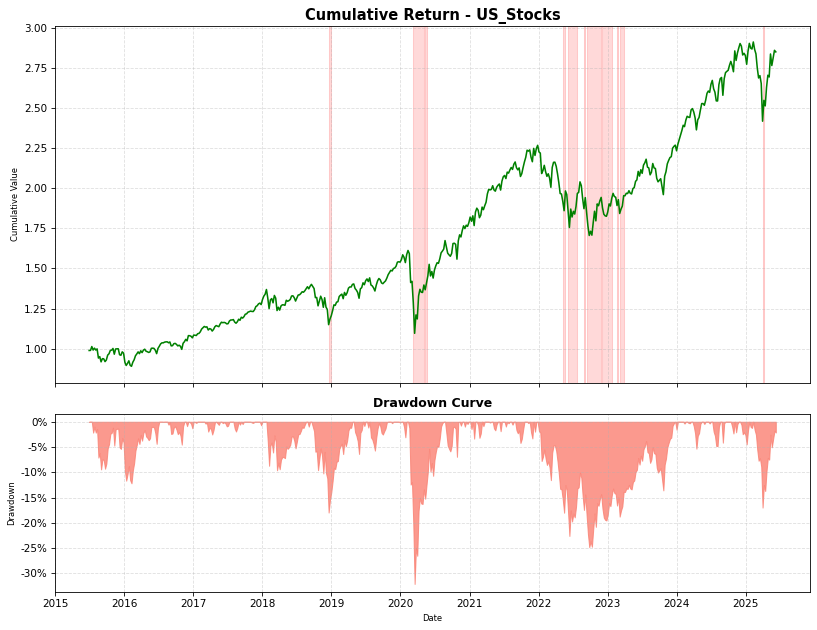

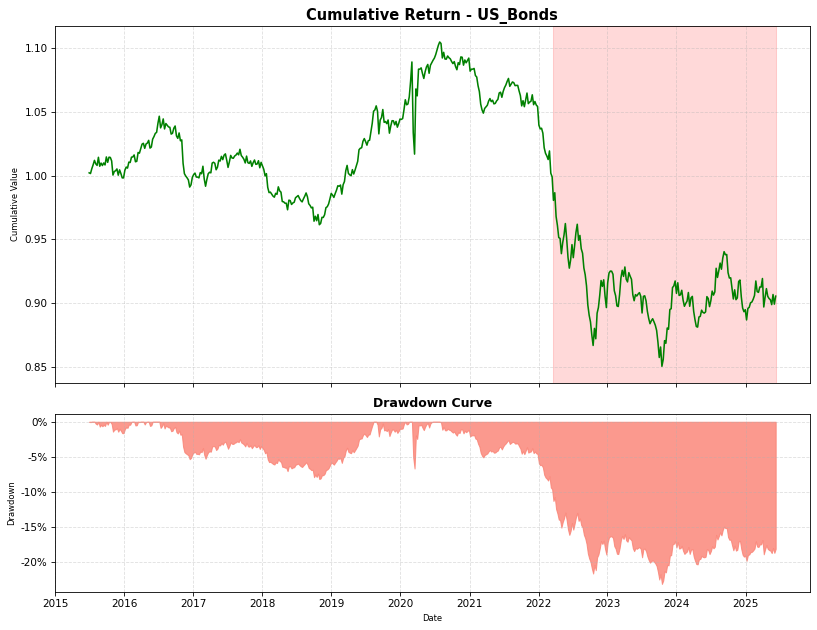

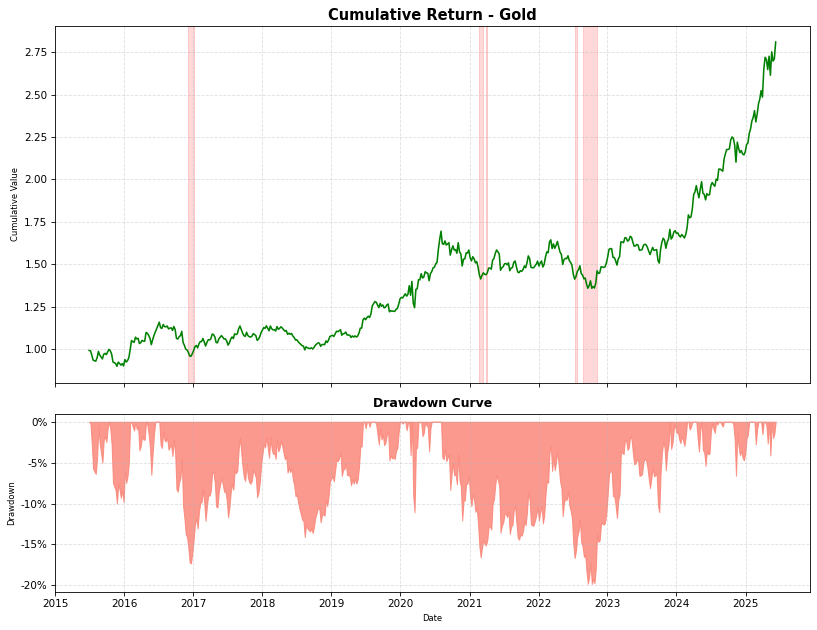

In [13]:
plot_drawdown_curve("US_Stocks", simple_returns['US_Stocks'], figures, threshold=-0.15)
plot_drawdown_curve("US_Bonds", simple_returns['US_Bonds'], figures, threshold=-0.10)
plot_drawdown_curve("Gold", simple_returns['Gold'], figures, threshold=-0.15)

## 14. Synchronized Drawdown Analysis

- Calculates and plots average drawdowns for global stocks and bonds.
- Highlights periods where both asset classes experience significant drawdowns simultaneously.

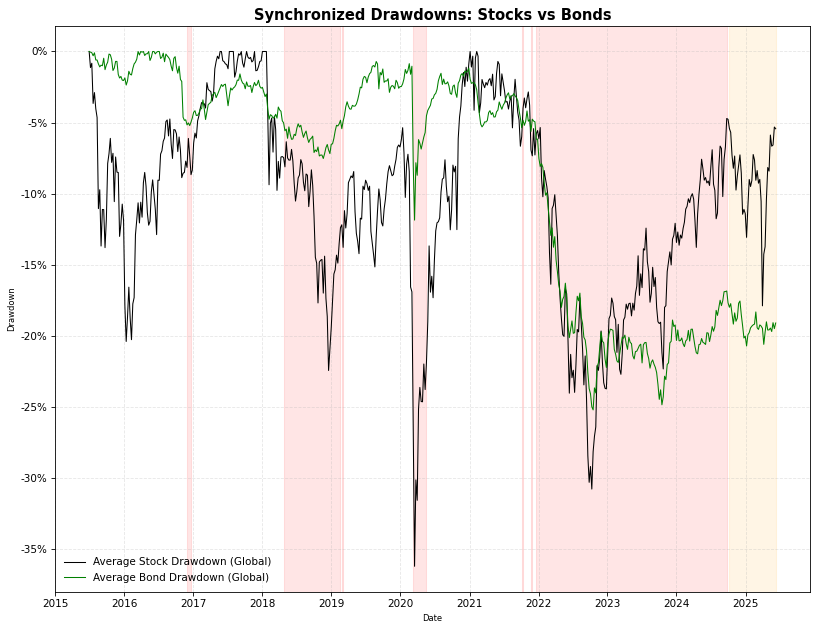

In [14]:
# Normalize asset prices (start all at 100)
normalized_prices = (1 + simple_returns).cumprod() * 100

# Compute drawdowns for each asset
drawdowns = pd.DataFrame(index=normalized_prices.index)
for col in normalized_prices.columns:
    peak = normalized_prices[col].cummax()
    drawdowns[col] = (normalized_prices[col] - peak) / peak

# Optional: group assets by type
stock_assets = ['US_Stocks', 'Dev_Stocks_ExUS', 'EM_Stocks']
bond_assets = ['US_Bonds', 'Dev_Bonds_ExUS', 'EM_Bonds']

# Calculate average stock and bond drawdowns
drawdowns['Stocks_Avg'] = drawdowns[stock_assets].mean(axis=1)
drawdowns['Bonds_Avg'] = drawdowns[bond_assets].mean(axis=1)

# === Plot synchronized drawdowns ===
fig_sync = plt.figure(figsize=(11, 8.5))
ax = fig_sync.add_subplot(111)

# Plot averaged stock and bond drawdowns
ax.plot(drawdowns.index, drawdowns['Stocks_Avg'], label='Average Stock Drawdown (Global)', color='black', linewidth=1)
ax.plot(drawdowns.index, drawdowns['Bonds_Avg'], label='Average Bond Drawdown (Global)', color='green', linewidth=1)

# Highlight synchronized drawdowns (both < -5% at same time)
sync = (drawdowns['Stocks_Avg'] < -0.05) & (drawdowns['Bonds_Avg'] < -0.05)
sync_regions = sync.astype(int).diff().fillna(0)

# Add shading
for i in range(1, len(sync_regions)):
    if sync_regions.iloc[i] == 1:
        start = drawdowns.index[i]
    elif sync_regions.iloc[i] == -1:
        end = drawdowns.index[i]
        ax.axvspan(start, end, color='red', alpha=0.1)

# If still in sync at end of series
if sync.iloc[-1]:
    ax.axvspan(start, drawdowns.index[-1], color='orange', alpha=0.1)

# Style the chart
# This chart shows synchronized drawdowns for stocks and bonds.
# "Stocks" and "Bonds" are each an average of US (domestic), developed ex-US, and emerging markets.
# Thus, the drawdown curves represent a global blend of all major market regions.
ax.set_title("Synchronized Drawdowns: Stocks vs Bonds", fontsize=14) 
ax.set_ylabel("Drawdown")
ax.set_xlabel("Date")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

fig_sync.tight_layout()
figures.append(fig_sync)

## 15. Factor Regression Analysis (CAPM & Multi-Factor)

- Calculates monthly returns and loads Fama-French and momentum factor data.
- Runs CAPM and multi-factor regressions for each asset.
- Visualizes CAPM beta, alpha, and multi-factor R².
- Summarizes regression results in a table.

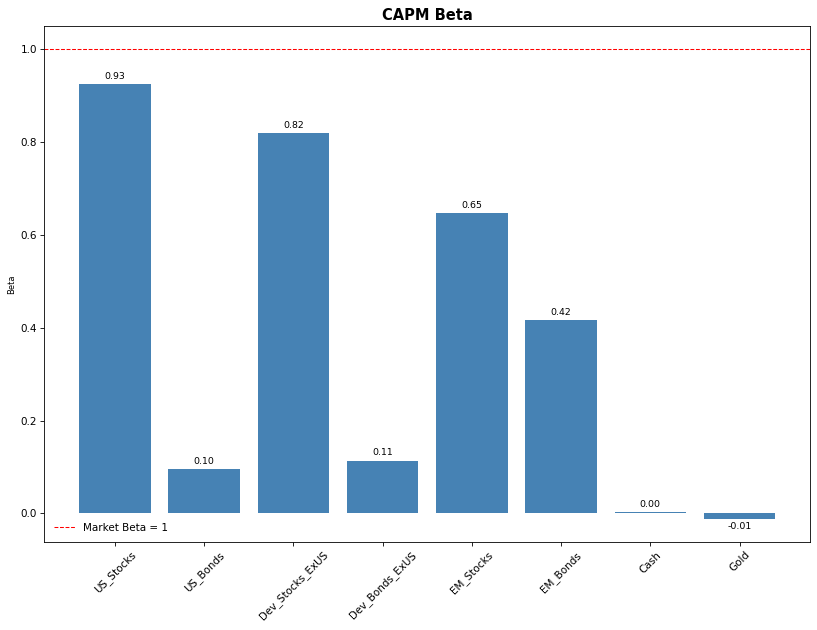

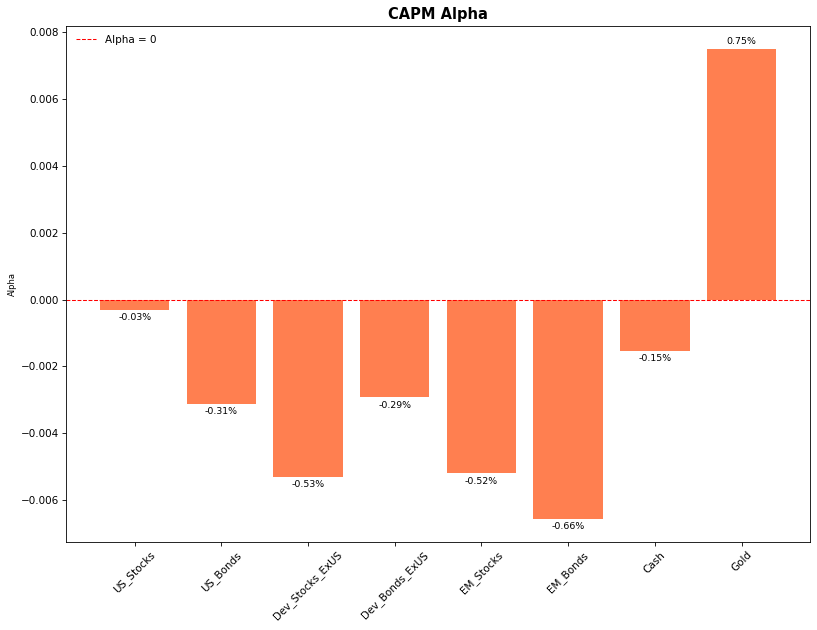

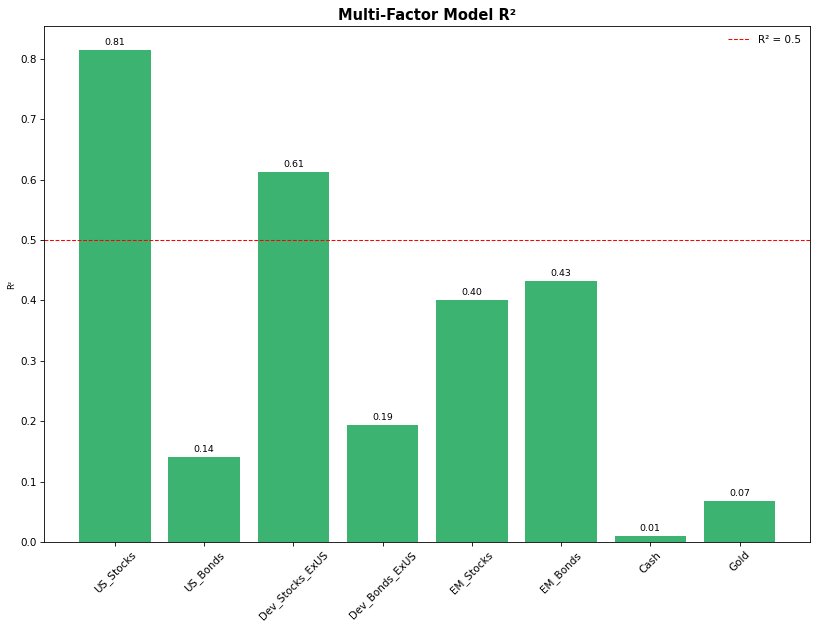

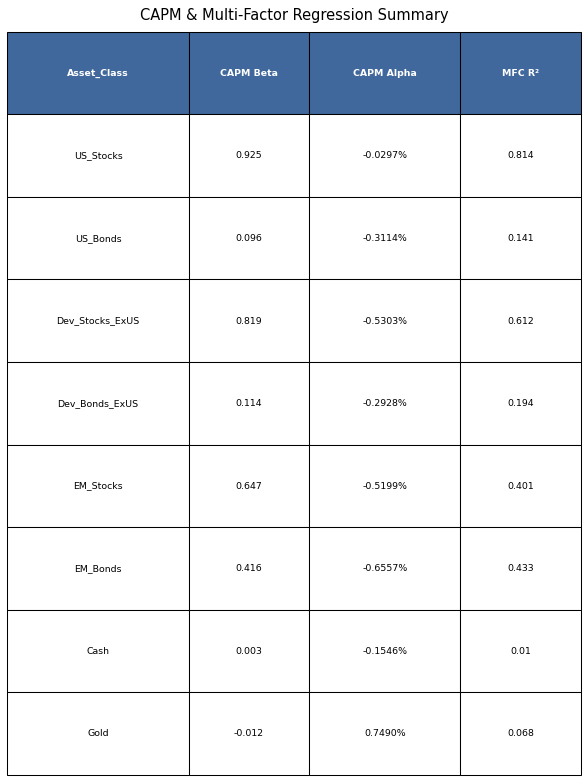

In [15]:
# Calculate monthly returns from weekly data
monthly_returns = simple_returns.resample('ME').apply(lambda x: (1 + x).prod() - 1)
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp('M') - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

# Download Fama-French factors and momentum data
# Load local CSVs from Kenneth French (already downloaded and cleaned)
ff_factors = pd.read_csv('data/F-F_Research_Data_Factor.csv', skiprows=3)
momentum = pd.read_csv('data/F-F_Momentum_Factor.csv', skiprows=13)

# Clean and parse dates
ff_factors = ff_factors.rename(columns={ff_factors.columns[0]: 'Date'})
# Keep only rows where 'Date' is a 6-digit string (YYYYMM)
ff_factors = ff_factors[ff_factors['Date'].astype(str).str.match(r'^\d{6}$')]
ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m')
# Set datetime as index and convert values to decimal
ff_factors.set_index('Date', inplace=True)
ff_factors = ff_factors.astype(float) / 100

# Optional: Rename for compatibility
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF']

momentum = momentum.rename(columns={momentum.columns[0]: 'Date'})
# Keep only rows where 'Date' is a 6-digit string (YYYYMM)
momentum = momentum[momentum['Date'].astype(str).str.match(r'^\d{6}$')]
momentum['Date'] = pd.to_datetime(momentum['Date'], format='%Y%m')
momentum.set_index('Date', inplace=True)
momentum = momentum.astype(float) / 100
momentum = momentum.rename(columns={momentum.columns[0]: 'Mom'})

# Merge with Fama-French data
ff_factors = ff_factors.join(momentum)
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF', 'Mom']

# Align dates with your monthly returns
common_end = min(monthly_returns.index.max(), ff_factors.index.max())
ff_factors_aligned = ff_factors.loc[monthly_returns.index.min():common_end]
monthly_returns_aligned = monthly_returns.loc[monthly_returns.index.min():common_end]

# Perform CAPM and Multi-Factor Model regressions
regression_results = {}
capm_betas, capm_alphas, mfc_r2 = [], [], []

for asset in monthly_returns.columns:
    df = pd.concat([monthly_returns[asset], ff_factors_aligned], axis=1).dropna()
    df.columns = ['Ret', 'Mkt_RF', 'SMB', 'HML', 'RF', 'Mom']

    if df.empty:
        print(f"⚠️ Skipping {asset}: no overlapping data.")
        continue

    y = df['Ret'] - df['RF']

    X_capm = sm.add_constant(df['Mkt_RF'])
    capm_model = sm.OLS(y, X_capm).fit()

    X_mfc = sm.add_constant(df[['Mkt_RF', 'SMB', 'HML']])
    mfc_model = sm.OLS(y, X_mfc).fit()

    regression_results[asset] = {'CAPM': capm_model, 'MFC': mfc_model}
    capm_betas.append(capm_model.params['Mkt_RF'])
    capm_alphas.append(capm_model.params['const'])
    mfc_r2.append(mfc_model.rsquared)

regression_assets = monthly_returns.columns.tolist()

# === Plot 1: CAPM Beta ===
fig_capm, ax = plt.subplots(figsize=(11, 8.5))
bars = ax.bar(regression_assets, capm_betas, color='steelblue')
ax.set_title('CAPM Beta', fontsize=14)
ax.set_ylabel('Beta')
ax.axhline(1, color='red', linestyle='--', linewidth=1, label='Market Beta = 1')
ax.set_xticks(range(len(regression_assets)))
ax.set_xticklabels(regression_assets, rotation=45)
ax.legend()
ax.bar_label(bars, labels=[f"{b:.2f}" for b in capm_betas], padding=3, fontsize=9)
plt.tight_layout()
figures.append(fig_capm)

# === Plot 2: CAPM Alpha ===
fig_alpha, ax = plt.subplots(figsize=(11, 8.5))
bars = ax.bar(regression_assets, capm_alphas, color='coral')
ax.set_title('CAPM Alpha', fontsize=14)
ax.set_ylabel('Alpha')
ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Alpha = 0')
ax.set_xticks(range(len(regression_assets)))
ax.set_xticklabels(regression_assets, rotation=45)
ax.legend()
ax.bar_label(bars, labels=[f"{a:.2%}" for a in capm_alphas], padding=3, fontsize=9)
plt.tight_layout()
figures.append(fig_alpha)

# === Plot 3: Multi-Factor R² ===
fig_multi, ax = plt.subplots(figsize=(11, 8.5))
bars = ax.bar(regression_assets, mfc_r2, color='mediumseagreen')
ax.set_title('Multi-Factor Model R²', fontsize=14)
ax.set_ylabel('R²')
ax.axhline(0.5, color='red', linestyle='--', linewidth=1, label='R² = 0.5')
ax.set_xticks(range(len(regression_assets)))
ax.set_xticklabels(regression_assets, rotation=45)
ax.legend()
ax.bar_label(bars, labels=[f"{r2:.2f}" for r2 in mfc_r2], padding=3, fontsize=9)
plt.tight_layout()
figures.append(fig_multi)

# Generate summary text for CAPM and Multi-Factor Model results
rows = []

for asset in regression_assets:
    capm = regression_results[asset]['CAPM']
    mfc = regression_results[asset]['MFC']

    rows.append({
        "Asset_Class": asset,
        "CAPM Beta": round(capm.params['Mkt_RF'], 3),
        "CAPM Alpha": f"{capm.params['const']:.4%}",
        "MFC R²": round(mfc.rsquared, 3)
    })

# Convert to DataFrame
regression_df = pd.DataFrame(rows)

fig_regg = plt.figure(figsize=(8.5, 11))
ax = fig_regg.add_axes([0.05, 0.05, 0.9, 0.9]) 
ax.axis('off')

table = ax.table(
    cellText=regression_df.values,
    colLabels=regression_df.columns,
    loc='center',
    cellLoc='center',
    bbox=[0, 0, 1, 1],
    colWidths=[0.3, 0.2, 0.25, 0.2]
)

header_props = {
    "facecolor": "#40689c",
    "edgecolor": "white",
    "text_props": {
        "weight": "bold",
        "color": "white",
        "fontsize": 10
    }
}

# Apply formatting to each header cell
for col_idx in range(len(regression_df.columns)):
    cell = table[(0, col_idx)]
    cell.set_facecolor(header_props["facecolor"])
    cell.get_text().set_fontweight(header_props["text_props"]["weight"])
    cell.get_text().set_color(header_props["text_props"]["color"])
    cell.get_text().set_fontsize(header_props["text_props"]["fontsize"])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)

plt.suptitle("CAPM & Multi-Factor Regression Summary", fontsize=14, y=0.98)
plt.show()
figures.append(fig_regg)


## 16. Portfolio Optimization with Constraints

- Simulates 50,000 random portfolios, enforcing user-specified min/max constraints for each asset.
- Identifies the portfolio with the maximum Sharpe ratio.
- Displays the optimal allocation and checks for constraint violations.
- Saves the optimal portfolio to CSV.

In [16]:
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 52
cov_matrix = returns.cov() * 52

# Portfolio simulation with constraints
num_portfolios = 100000
results = np.zeros((3, num_portfolios))
weights_record = []
   

for i in range(num_portfolios):
    while True:
        weights = np.random.random(len(assets))
        weights /= np.sum(weights)

        # Enforce min/max constraints
        valid = True
        for j, asset in enumerate(assets):
            if asset in constraints:
                rule = constraints[asset]
                if 'max' in rule and weights[j] > rule['max']:
                    valid = False
                    break
                if 'min' in rule and weights[j] < rule['min']:
                    valid = False
                    break
        if valid:
            break

    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - risk_free_rate) / port_volatility

    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe
    weights_record.append(weights)

# Find portfolio with max Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_record[max_sharpe_idx]
optimal_portfolio = pd.Series(optimal_weights, index=assets)
opt_port = optimal_portfolio.reset_index()
opt_port.columns = ['Asset_Class', 'Weight']


# Calculate optimal portfolio metrics
optimal_volatility = results[1, max_sharpe_idx]
optimal_return = results[0, max_sharpe_idx]
max_sharpe = results[2, max_sharpe_idx]

# Print optimal allocation
print("Optimal Portfolio Allocation (with Constraints):")
print(opt_port.round(4))
print(f"Expected Annual Return: {optimal_return:.4f}")
print(f"Expected Annual Volatility: {optimal_volatility:.4f}")  
print(f"Max Sharpe Ratio: {max_sharpe:.4f}")

for asset, weight in zip(assets, optimal_weights):
    if asset in constraints:
        rule = constraints[asset]
        if 'min' in rule and weight < rule['min']:
            print(f"❌ {asset} violates MIN: {weight:.4f} < {rule['min']}")
        if 'max' in rule and weight > rule['max']:
            print(f"❌ {asset} violates MAX: {weight:.4f} > {rule['max']}")

# Save optimal portfolio to CSV

opt_port.to_csv("exports/optimal_portfolio_with_constraints.csv")
print("Optimal portfolio saved as 'optimal_portfolio_with_constraints.csv' in exports directory.")

Optimal Portfolio Allocation (with Constraints):
       Asset_Class  Weight
0        US_Stocks  0.5488
1         US_Bonds  0.2323
2  Dev_Stocks_ExUS  0.0076
3   Dev_Bonds_ExUS  0.0308
4        EM_Stocks  0.0249
5         EM_Bonds  0.0057
6             Cash  0.0530
7             Gold  0.0968
Expected Annual Return: 0.0759
Expected Annual Volatility: 0.1075
Max Sharpe Ratio: 0.2959
Optimal portfolio saved as 'optimal_portfolio_with_constraints.csv' in exports directory.


## 17. Efficient Frontier and Portfolio Comparison

- Plots the efficient frontier, highlights the optimal portfolio, and overlays the Capital Market Line (CML).
- Visualizes the optimal portfolio allocation as a bar chart.
- Compares optimal and minimum variance portfolios in side-by-side tables.

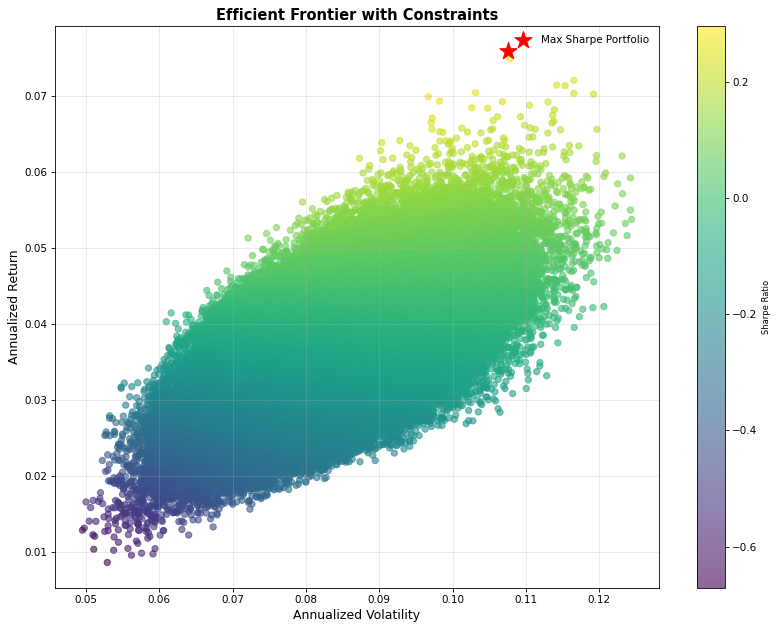

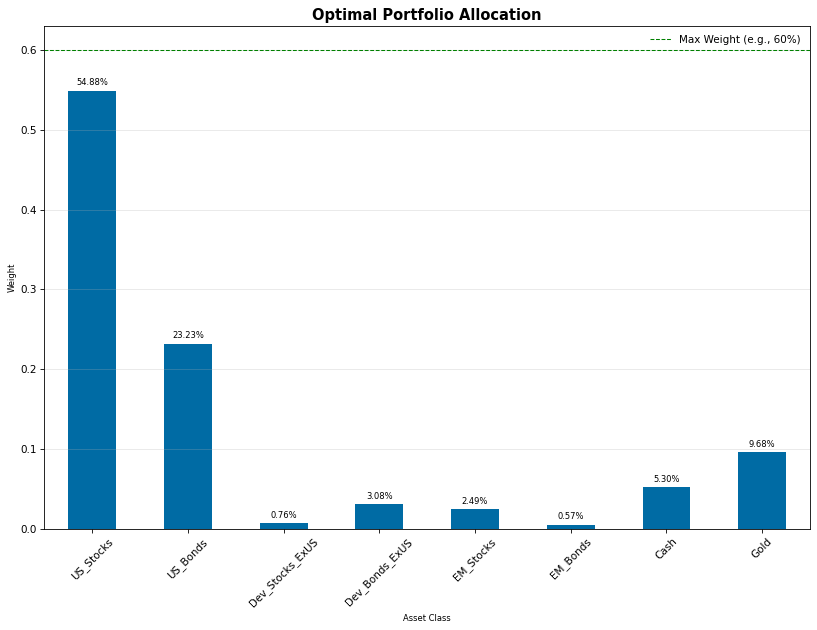

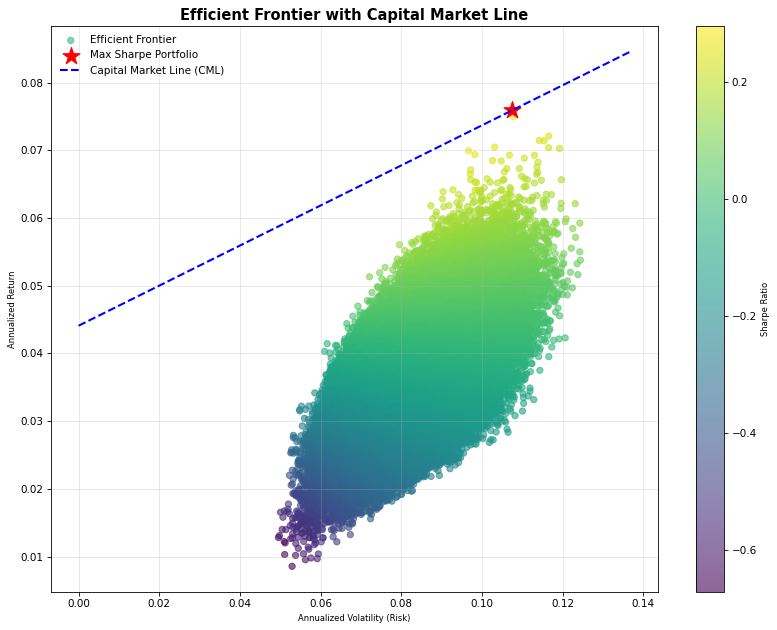

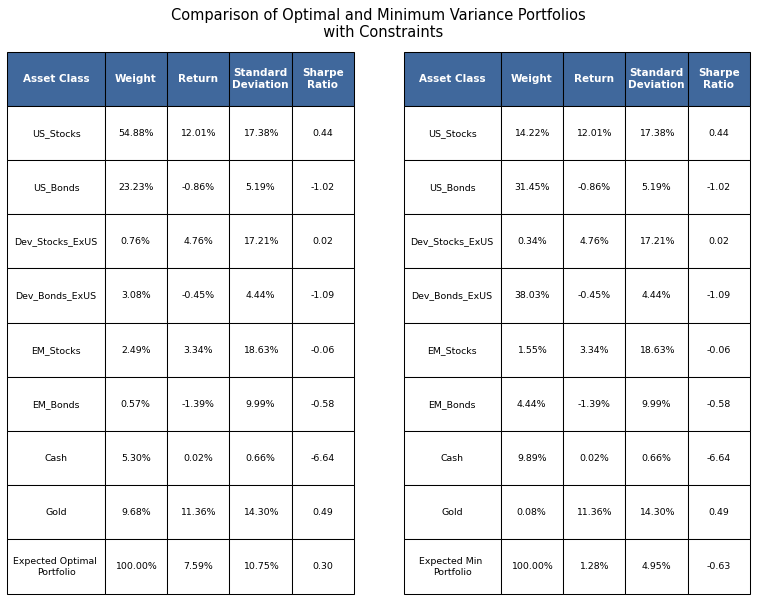

In [17]:
# Plot efficient frontier
fig1 = plt.figure(figsize=(11, 8.5))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=300, label='Max Sharpe Portfolio')
plt.title("Efficient Frontier with Constraints", fontsize=14)
plt.xlabel("Annualized Volatility", fontsize=12)
plt.ylabel("Annualized Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
figures.append(fig1)


fig2, ax = plt.subplots(figsize=(11, 8.5))

# Plot and get BarContainer
bars = optimal_portfolio.plot(kind='bar', ax=ax)

ax.set_title("Optimal Portfolio Allocation", fontsize=14)
ax.set_ylabel("Weight")
ax.set_xlabel("Asset Class")
ax.grid(axis='y')
ax.axhline(y=0.6, color='green', linestyle='--', linewidth=1, label='Max Weight (e.g., 60%)')

# Add bar labels (percentage)
ax.bar_label(ax.containers[0], labels=[f"{w:.2%}" for w in optimal_portfolio], label_type='edge', fontsize=8, padding=3)

ax.set_xticklabels(optimal_portfolio.index, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

figures.append(fig2)

# Define x-axis range: from 0 to a bit beyond the optimal volatility
x = np.linspace(0, max(results[1]) * 1.1, 100)

# CML equation: R = Rf + Sharpe * σ
cml = risk_free_rate + max_sharpe * x

# Plot Efficient Frontier
fig3 = plt.figure(figsize=(11, 8.5))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6, label='Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=300, label='Max Sharpe Portfolio')
plt.plot(x, cml, color='blue', linestyle='--', linewidth=2, label='Capital Market Line (CML)')
plt.title("Efficient Frontier with Capital Market Line")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
figures.append(fig3)

annual_returns = mean_returns
annual_vols = simple_returns.std() * np.sqrt(52)
sharpe_series = (annual_returns - risk_free_rate) / annual_vols

table_df = pd.DataFrame({
    "Weight": optimal_portfolio.round(4).apply(lambda x: f"{x:.2%}"),
    "Return": annual_returns.round(4).apply(lambda x: f"{x:.2%}"),
    "Std Dev": annual_vols.round(4).apply(lambda x: f"{x:.2%}"),
    "Sharpe Ratio": sharpe_series.round(4).apply(lambda x: f"{x:.2f}")
}).loc[optimal_portfolio.index]

table_df = table_df.reset_index().rename(columns={"Ticker": "Asset_Class"})

summary_row = pd.DataFrame({
    "Asset_Class": ["Expected Optimal \nPortfolio"],
    "Weight": [f"{optimal_portfolio.sum():.2%}"],
    "Return": [f"{optimal_return:.2%}"],
    "Std Dev": [f"{optimal_volatility:.2%}"],
    "Sharpe Ratio": [f"{max_sharpe:.2f}"]
})

table_df = pd.concat([table_df, summary_row], ignore_index=True)

# Calculate minimum variance portfolio
sharpe_ratios = results[2]
portfolio_returns = results[0]
portfolio_vols = results[1]
min_var_idx = np.argmin(portfolio_vols)
min_var_weights = weights_record[min_var_idx]

min_var_return = portfolio_returns[min_var_idx]
min_var_volatility = portfolio_vols[min_var_idx]
min_var_ratio = sharpe_ratios[min_var_idx]

# === Create table for min variance portfolio ===
minvar_table_df = pd.DataFrame({
    "Weight": pd.Series(min_var_weights, index=assets).round(4).apply(lambda x: f"{x:.2%}"),
    "Return": annual_returns.round(4).apply(lambda x: f"{x:.2%}"),
    "Std Dev": annual_vols.round(4).apply(lambda x: f"{x:.2%}"),
    "Sharpe Ratio": sharpe_series.round(4).apply(lambda x: f"{x:.2f}")
}).loc[assets]

minvar_table_df = minvar_table_df.reset_index().rename(columns={"Ticker": "Asset_Class"})

minvar_summary_row = pd.DataFrame({
    "Asset_Class": ["Expected Min \nPortfolio"],
    "Weight": [f"{sum(min_var_weights):.2%}"],
    "Return": [f"{min_var_return:.2%}"],
    "Std Dev": [f"{min_var_volatility:.2%}"],
    "Sharpe Ratio": [f"{min_var_ratio:.2f}"]
})

minvar_table_df = pd.concat([minvar_table_df, minvar_summary_row], ignore_index=True)


# === Create figure with 2 side-by-side tables ===
fig_compare = plt.figure(figsize=(11, 8.5))
ax1 = fig_compare.add_axes([0.05, 0.05, 0.42, 0.85])
ax2 = fig_compare.add_axes([0.53, 0.05, 0.42, 0.85])

ax1.axis('off')
ax2.axis('off')

# Optimal Portfolio Table
table1 = ax1.table(
    cellText=table_df.values,
    colLabels=['Asset Class', 'Weight', 'Return', 'Standard\nDeviation', 'Sharpe\nRatio'],
    cellLoc='center',
    loc='center',
    colWidths=[0.28, 0.18, 0.18, 0.18, 0.18],
    bbox=[0, 0, 1, 1]
)

# Minimum Variance Table
table2 = ax2.table(
    cellText=minvar_table_df.values,
    colLabels=['Asset Class', 'Weight', 'Return', 'Standard\nDeviation', 'Sharpe\nRatio'],
    cellLoc='center',
    loc='center',
    colWidths=[0.28, 0.18, 0.18, 0.18, 0.18],
    bbox=[0, 0, 1, 1]
)

# === Style both table headers ===
for t in [table1, table2]:
    t.auto_set_font_size(False)
    t.set_fontsize(9)
    t.scale(1.2, 1.2)
    for col_idx in range(len(table_df.columns)):
        cell = t[(0, col_idx)]
        cell.set_facecolor("#40689c")
        cell.get_text().set_fontweight("bold")
        cell.get_text().set_color("white")
        cell.get_text().set_fontsize(10)

# === Add shared title ===
fig_compare.suptitle("Comparison of Optimal and Minimum Variance Portfolios\n  with Constraints", fontsize=14, y=0.97)

# === Save to export list ===
figures.append(fig_compare)

## 18. Backtest Summary Panel

This section creates a comprehensive backtest summary panel comparing the performance of the Max Sharpe portfolio (the optimal portfolio found in the optimization step) against a traditional 60/40 benchmark (60% US Stocks, 40% US Bonds).

**Key steps in the code:**

- **Benchmark Construction:**  
    The benchmark is constructed by weighting the weekly returns of US Stocks and US Bonds according to a 60/40 split.

- **Max Sharpe Portfolio Returns:**  
    The returns for the Max Sharpe portfolio are calculated by applying the optimal weights to the weekly returns of all assets.

- **Backtest DataFrame:**  
    Both the Max Sharpe and benchmark returns are combined into a single DataFrame for analysis.

- **Summary Panel Function:**  
    The `plot_backtest_summary_panel` function:
    - Infers the frequency of the return data for correct annualization.
    - Calculates cumulative returns, drawdowns, and key performance metrics (annualized return, volatility, Sharpe ratio, Sortino ratio, and max drawdown) for both portfolios.
    - Plots:
        - A bar chart of cumulative returns.
        - A summary statistics table.
        - Cumulative return curves over time.
        - Drawdown curves for both portfolios.

- **Figure Export:**  
    The resulting summary panel figure is appended to the `figures` list for inclusion in the final PDF report.

**Purpose:**  
This section provides a clear, side-by-side visual and tabular comparison of the optimized portfolio versus a standard benchmark, helping to evaluate the effectiveness of the optimization process in real-world, historical terms.

C:\Users\opelc\AppData\Local\Temp\ipykernel_42724\1396309096.py:118: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



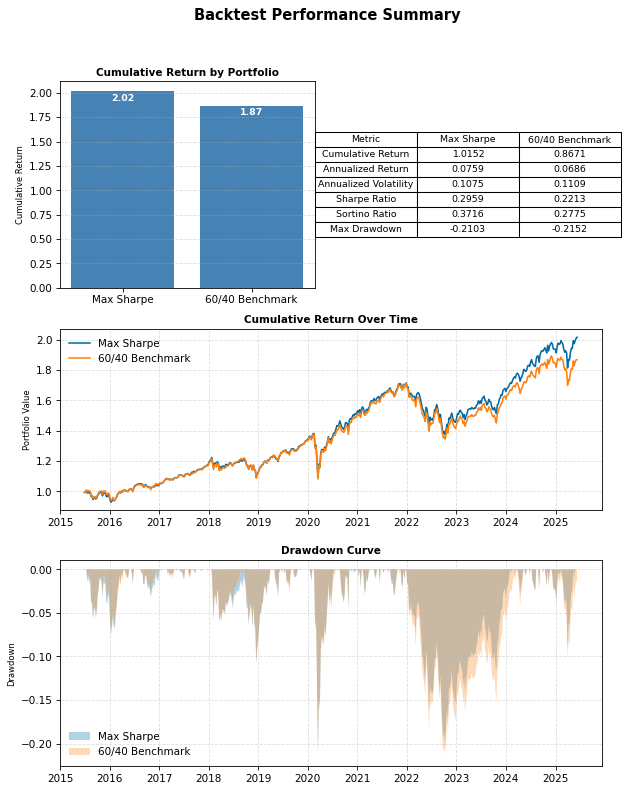

In [18]:
# == Backtest Summary Panel ==
# This section creates a backtest summary panel comparing the Max Sharpe portfolio against a 60/40 benchmark.
# Ensure simple_returns is defined as the weekly returns DataFrame
# Define benchmark
benchmark_weights = {
    "US_Stocks": 0.60,
    "US_Bonds": 0.40
}

benchmark_return_series = simple_returns[list(benchmark_weights.keys())].dot(
    pd.Series(benchmark_weights)
)
benchmark_cumulative = (1 + benchmark_return_series).cumprod() * 100

# Max Sharpe returns
weights = optimal_portfolio.loc[simple_returns.columns].values
max_sharpe_returns = simple_returns.dot(weights)

# 60/40 benchmark returns
benchmark_returns = simple_returns[["US_Stocks", "US_Bonds"]].dot(pd.Series({
    "US_Stocks": 0.6,
    "US_Bonds": 0.4
}))

# Combine into one DataFrame for analysis
backtest_returns = pd.DataFrame({
    "Max Sharpe": max_sharpe_returns,
    "60/40 Benchmark": benchmark_returns
})


def plot_backtest_summary_panel(backtest_returns, rf_rate=0.0):
    # Infer frequency for annualization
    if backtest_returns.index.freq is not None:
        inferred_freq = backtest_returns.index.freqstr
    else:
        inferred_freq = pd.infer_freq(backtest_returns.index)

    if inferred_freq.startswith('D'):
        freq = 252
    elif inferred_freq.startswith('W'):
        freq = 52
    elif inferred_freq.startswith('M'):
        freq = 12
    else:
        freq = 252  # default fallback
    cum_returns = (1 + backtest_returns).cumprod()
    drawdowns = cum_returns.divide(cum_returns.cummax()) - 1

    # Prepare summary stats table
    summary_stats = pd.DataFrame({
        "Max Sharpe": {
            "Cumulative Return": cum_returns["Max Sharpe"].iloc[-1] - 1,
            "Annualized Return": backtest_returns["Max Sharpe"].mean() * freq,
            "Annualized Volatility": backtest_returns["Max Sharpe"].std() * np.sqrt(freq),
            "Sharpe Ratio": (backtest_returns["Max Sharpe"].mean() * freq - rf_rate) /
                            (backtest_returns["Max Sharpe"].std() * np.sqrt(freq)),
            "Sortino Ratio": (backtest_returns["Max Sharpe"].mean() * freq - rf_rate) /
                             (backtest_returns["Max Sharpe"][backtest_returns["Max Sharpe"] < 0].std() * np.sqrt(freq)),
            "Max Drawdown": drawdowns["Max Sharpe"].min()
        },
        "60/40 Benchmark": {
            "Cumulative Return": cum_returns["60/40 Benchmark"].iloc[-1] - 1,
            "Annualized Return": backtest_returns["60/40 Benchmark"].mean() * freq,
            "Annualized Volatility": backtest_returns["60/40 Benchmark"].std() * np.sqrt(freq),
            "Sharpe Ratio": (backtest_returns["60/40 Benchmark"].mean() * freq - rf_rate) /
                            (backtest_returns["60/40 Benchmark"].std() * np.sqrt(freq)),
            "Sortino Ratio": (backtest_returns["60/40 Benchmark"].mean() * freq - rf_rate) /
                             (backtest_returns["60/40 Benchmark"][backtest_returns["60/40 Benchmark"] < 0].std() * np.sqrt(freq)),
            "Max Drawdown": drawdowns["60/40 Benchmark"].min()
        }
    }).round(4)
    
    summary_stats = summary_stats.reset_index().rename(columns={"index": "Metric"})

    fig = plt.figure(figsize=(8.5, 11))

    # --- Top Row: Bar chart (left), Summary table (right) ---
    ax_bar = fig.add_axes([0.08, 0.65, 0.40, 0.25])
    bars = ax_bar.bar(cum_returns.columns, cum_returns.iloc[-1], color='steelblue')
    ax_bar.set_title("Cumulative Return by Portfolio", fontsize=10)
    ax_bar.set_ylabel("Cumulative Return")
    for bar in bars:
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width() / 2., height * 0.99, f"{height:.2f}",
                    ha='center', va='top', color='white', fontsize=9, fontweight='bold')
    ax_bar.grid(axis='y', linestyle='--', alpha=0.4)

    ax_table = fig.add_axes([0.52, 0.65, 0.4, 0.25])
    ax_table.axis('off')
    table = ax_table.table(cellText=summary_stats.values,
                           colLabels=summary_stats.columns,
                           loc='center',
                           cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)

    # --- Middle: Cumulative return over time ---
    ax2 = fig.add_axes([0.08, 0.38, 0.85, 0.22])
    for col in cum_returns.columns:
        ax2.plot(cum_returns.index, cum_returns[col], label=col)
    ax2.set_title("Cumulative Return Over Time", fontsize=10)
    ax2.set_ylabel("Portfolio Value")
    ax2.grid(True, linestyle='--', alpha=0.4)
    ax2.legend()

    # --- Bottom: Drawdown curve ---
    ax3 = fig.add_axes([0.08, 0.07, 0.85, 0.25])
    for col in drawdowns.columns:
        ax3.fill_between(drawdowns.index, drawdowns[col], alpha=0.3, label=col)
    ax3.set_title("Drawdown Curve", fontsize=10)
    ax3.set_ylabel("Drawdown")
    ax3.grid(True, linestyle='--', alpha=0.4)
    ax3.legend()

    fig.suptitle("Backtest Performance Summary", fontsize=14, weight='bold', y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    
    return fig

# Generate the backtest summary panel
backtest_summary_panel = plot_backtest_summary_panel(backtest_returns, rf_rate=risk_free_rate)
figures.append(backtest_summary_panel)

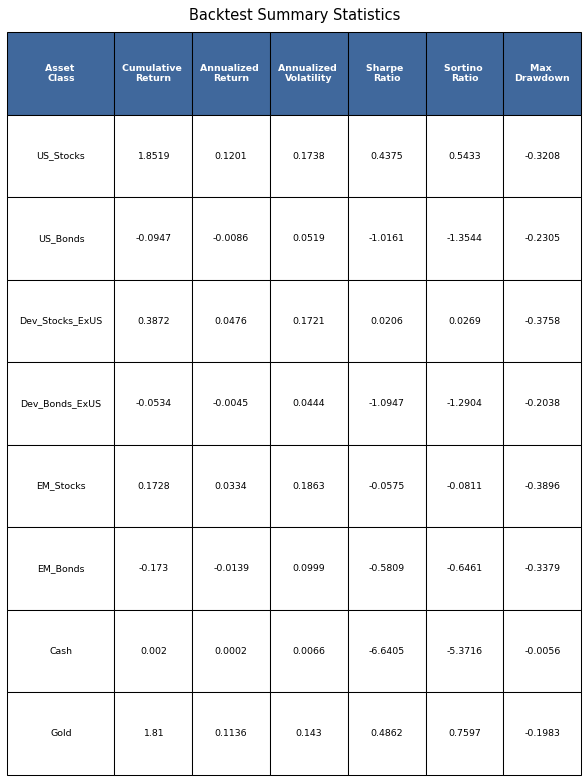

In [19]:
# Infer frequency for annualization
if backtest_returns.index.freq is not None:
    inferred_freq = backtest_returns.index.freqstr
else:
    inferred_freq = pd.infer_freq(backtest_returns.index)

if inferred_freq.startswith('D'):
    freq = 252
elif inferred_freq.startswith('W'):
    freq = 52
elif inferred_freq.startswith('M'):
    freq = 12
else:
    freq = 252  # default fallback
    
mean_returns = returns.mean() * freq
std_returns = returns.std() * np.sqrt(freq)
sharpe = (mean_returns - risk_free_rate) / std_returns
sortino = (mean_returns - risk_free_rate) / (returns[returns < 0].std() * np.sqrt(freq))
cum_returns = (1 + returns).cumprod()
total_cum_return = cum_returns.iloc[-1] - 1
max_dd = (cum_returns / cum_returns.cummax() - 1).min()

summary_df = pd.DataFrame({
    'Cumulative Return': total_cum_return,
    'Annualized Return': mean_returns,
    'Annualized Volatility': std_returns,
    'Sharpe Ratio': sharpe,
    'Sortino Ratio': sortino,
    'Max Drawdown': max_dd
}).round(4)

summary_df = summary_df.reset_index().rename(columns={"Ticker": "Asset Class"})

fig_backsummary = plt.figure(figsize=(8.5, 11))
ax_summary = fig_backsummary.add_axes([0.05, 0.05, 0.9, 0.9])
ax_summary.axis('off')
table_summary = ax_summary.table(
    cellText=summary_df.values,
    # Ensure the first column is labeled "Asset Class"
    colLabels= ['Asset \nClass', 'Cumulative \nReturn', 'Annualized \nReturn',
                'Annualized \nVolatility', 'Sharpe \nRatio', 'Sortino \nRatio', 'Max \nDrawdown'],
    loc='center',
    cellLoc='center',
    bbox=[0, 0, 1, 1],
    colWidths=[0.22, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16]
)

# Header formatting
for col_idx in range(len(summary_df.columns)):
    cell = table_summary[(0, col_idx)]
    cell.set_facecolor("#40689c")
    cell.get_text().set_fontweight("bold")
    cell.get_text().set_color("white")
    cell.get_text().set_fontsize(10)
table_summary.auto_set_font_size(False)
table_summary.set_fontsize(9)
table_summary.scale(1.2, 1.2)

plt.suptitle("Backtest Summary Statistics", fontsize=14, y=0.98)
figures.append(fig_backsummary)


In [20]:
# Utility functions and initialization for figure collection and PDF report generation
def generate_pdf_report(figures, text_pages=None, filename="exports/portfolio_summary_report.pdf"):
    """
    Save a list of matplotlib figures and optional text pages to a single PDF report.
    
    Parameters:
    - figures (list): List of matplotlib Figure objects.
    - text_pages (list): Optional list of strings to render as pages of text.
    - filename (str): Output PDF file path.
    """
    pdf_path = Path(filename)
    pdf_path.parent.mkdir(parents=True, exist_ok=True)

    with PdfPages(pdf_path) as pdf:
        # Save all figure pages
        for fig in figures:
            pdf.savefig(fig)
            plt.close(fig)

        # Save text pages if provided
        if text_pages:
            for text in text_pages:
                fig_text = plt.figure(figsize=(8.5, 11))
                plt.axis('off')
                plt.text(0, 1, text, fontsize=10, verticalalignment='top', fontfamily='arial', wrap=True)
                pdf.savefig(fig_text)
                plt.close(fig_text)

    return str(pdf_path)

# Generate PDF report with all figures and optional text pages
generate_pdf_report(figures, text_pages=None)

print("Portfolio analysis report generated as 'portfolio_analysis_report.pdf' in exports directory.")

Portfolio analysis report generated as 'portfolio_analysis_report.pdf' in exports directory.
